###  @CodeClause Project : Image Caption Generator

In [12]:
#!pip install tensorflow

^C


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
# from tensorflow.keras.layers.merge import add
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, concatenate
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import add

In [7]:
# Reading the Description file

with open('D:/PROGRAMMING/PYTHON/Data Science & Analysis/Pr_4_Image Caption Generator/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt') as filepath:
    captions = filepath.read()
    filepath.close()

In [8]:
captions = captions.split("\n")[:-1]

In [9]:
len(captions)

40460

In [11]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [12]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """ 

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [14]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [15]:
#  modify all the captions i.e - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [16]:
#  clean descriptions

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [18]:
# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [20]:
#  reading description file

f = open("descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [21]:
# finding the unique vocabulary 

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [22]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [23]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [24]:
len(all_vocab)

1845

In [25]:
# TrainImagesFile
f = open("D:/PROGRAMMING/PYTHON/Data Science & Analysis/Pr_4_Image Caption Generator/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [26]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [27]:
# TestImagesFile
f = open("D:/PROGRAMMING/PYTHON/Data Science & Analysis/Pr_4_Image Caption Generator/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [28]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [29]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [30]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [31]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

102967424/102967424 [==============================] - 58s 1us/step


In [32]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [33]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [34]:
images = "D:/PROGRAMMING/PYTHON/Data Science & Analysis/Pr_4_Image Caption Generator/flickr8k-sau/Flickr_Data/Images/"

In [35]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [36]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [37]:
start = time()

encoding_train = {}

for ix, img in enumerate(train):
    
    img = "D:/PROGRAMMING/PYTHON/Data Science & Analysis/Pr_4_Image Caption Generator/flickr8k-sau/Flickr_Data/Images/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 2s 2s/step
Encoding image- 0
1/1 [==============================] - 0s 88ms/step
Encoding image- 100
1/1 [==============================] - 0s 203ms/step


1/1 [==============================] - 0s 159ms/step
Encoding image- 200
1/1 [==============================] - 0s 114ms/step
Encoding image- 300
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 114ms/step
Encoding image- 400
1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 99ms/step
Encoding image- 500
1/1 [==============================] - 0s 99ms/step
Encoding image- 600
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 108ms/step
Encoding image- 700
1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 139ms/step
Encoding image- 800
1/1 [==============================] - 0s 125ms/step
Encoding image- 900
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 108ms/step
Encoding image- 1000
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 110ms/step
Encoding image- 1100
1/1 [==============================] - 0s 94ms/step
Encoding image- 1200
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 107ms/step
Encoding image- 1300
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 123ms/step
Encoding image- 1400
1/1 [==============================] - 0s 92ms/step
Encoding image- 1500
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 124ms/step
Encoding image- 1600
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 127ms/step
Encoding image- 1700
1/1 [==============================] - 0s 94ms/step
Encoding image- 1800
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 95ms/step
Encoding image- 1900
1/1 [==============================] - 0s 95ms/step
Encoding image- 2000
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 114ms/step
Encoding image- 2100
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 94ms/step
Encoding image- 2200
1/1 [==============================] - 0s 117ms/step
Encoding image- 2300
1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 214ms/step
Encoding image- 2400
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 111ms/step
Encoding image- 2500
1/1 [==============================] - 0s 110ms/step
Encoding image- 2600
1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step
Encoding image- 2700
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 105ms/step
Encoding image- 2800
1/1 [==============================] - 0s 150ms/step
Encoding image- 2900
1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 172ms/step
Encoding image- 3000
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 125ms/step
Encoding image- 3100
1/1 [==============================] - 0s 116ms/step
Encoding image- 3200
1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 97ms/step
Encoding image- 3300
1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 106ms/step
Encoding image- 3400
1/1 [==============================] - 0s 102ms/step
Encoding image- 3500
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 105ms/step
Encoding image- 3600
1/1 [==============================] - 0s 112ms/step
Encoding image- 3700
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 102ms/step
Encoding image- 3800
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 103ms/step
Encoding image- 3900
1/1 [==============================] - 0s 125ms/step
Encoding image- 4000
1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 222ms/step
Encoding image- 4100
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 122ms/step
Encoding image- 4200
1/1 [==============================] - 0s 103ms/step
Encoding image- 4300
1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 112ms/step
Encoding image- 4400
1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 93ms/step
Encoding image- 4500
1/1 [==============================] - 0s 119ms/step
Encoding image- 4600
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 116ms/step
Encoding image- 4700
1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 112ms/step
Encoding image- 4800
1/1 [==============================] - 0s 135ms/step
Encoding image- 4900
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 211ms/step
Encoding image- 5000
1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 125ms/step
Encoding image- 5100
1/1 [==============================] - 0s 133ms/step
Encoding image- 5200
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 115ms/step
Encoding image- 5300
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 109ms/step
Encoding image- 5400
1/1 [==============================] - 0s 105ms/step
Encoding image- 5500
1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 122ms/step
Encoding image- 5600
1/1 [==============================] - 0s 125ms/step
Encoding image- 5700
1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 112ms/step
Encoding image- 5800
1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 144ms/step
Encoding image- 5900
1/1 [==============================] - 0s 122ms/step
Time taken in seconds = 1133.814924955368


In [38]:
# Save the bottleneck train features to disk

with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [39]:
start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "D:/PROGRAMMING/PYTHON/Data Science & Analysis/Pr_4_Image Caption Generator/flickr8k-sau/Flickr_Data/Images/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 143ms/step
Encoding image- 0
1/1 [==============================] - 0s 121ms/step
Encoding image- 100
1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 156ms/step
Encoding image- 200
1/1 [==============================] - 0s 118ms/step
Encoding image- 300
1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 119ms/step
Encoding image- 400
1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 126ms/step
Encoding image- 500
1/1 [==============================] - 0s 138ms/step
Encoding image- 600
1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 122ms/step
Encoding image- 700
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 122ms/step
Encoding image- 800
1/1 [==============================] - 0s 130ms/step
Encoding image- 900
1/1 [==============================] - 0s 199ms/step


1/1 [==============================] - 0s 126ms/step
Time taken in seconds = 225.61082124710083


In [40]:
# Save the bottleneck train features to disk

with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [41]:
# Load the train images features from disk

with open("encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [42]:
# Load the test images features from disk

with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [43]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

In [44]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [45]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [46]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


In [47]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

In [48]:
f = open("glove.6B.50d.txt", encoding='utf8')

In [49]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

In [50]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [51]:
embedding_output.shape

(1848, 50)

In [52]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [53]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [54]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [55]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [56]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [57]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [58]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [59]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

C:\Users\Acer\AppData\Local\Temp\ipykernel_16912\259339223.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


2000/2000 [==============================] - 415s 207ms/step - loss: 2.7881


In [60]:
model = load_model("./model_weights/model_9.h5")

In [61]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

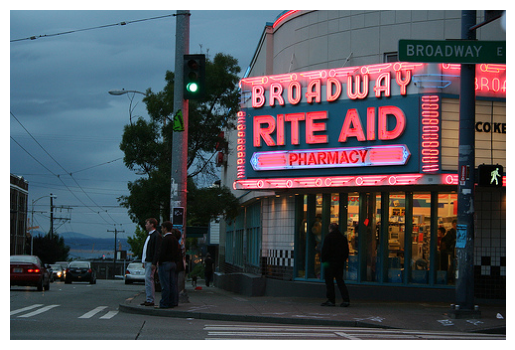

1/1 [==============================] - 0s 51ms/step
man in black shirt is standing on the corner of front of store


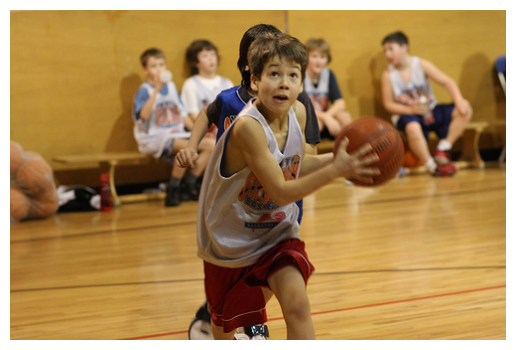

1/1 [==============================] - 0s 31ms/step
basketball player in white uniform is dribbling the ball


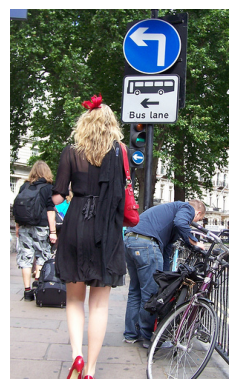

1/1 [==============================] - 0s 50ms/step
man in black shirt and black shorts is riding on street


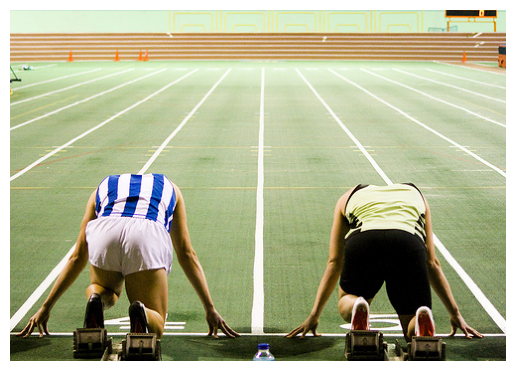

1/1 [==============================] - 0s 15ms/step
man in blue shirt is playing cricket


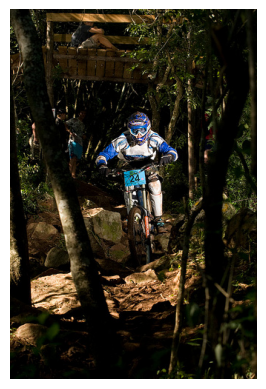

1/1 [==============================] - 0s 31ms/step
helmeted man rides bicycle through forest


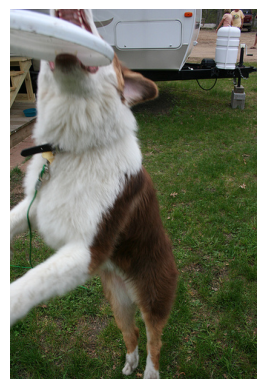

1/1 [==============================] - 0s 42ms/step
dog is jumping up to catch ball


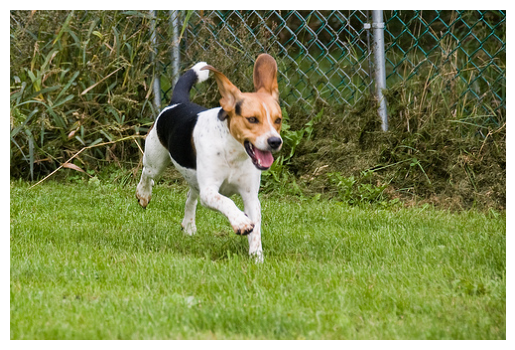

1/1 [==============================] - 0s 37ms/step
dog jumps over frisbee


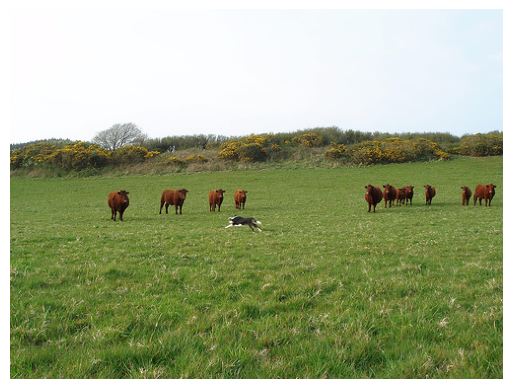

1/1 [==============================] - 0s 32ms/step
two dogs are running through the countryside


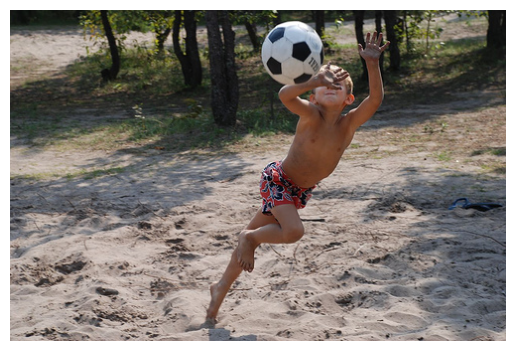

1/1 [==============================] - 0s 31ms/step
boy in blue shirt is jumping in the air


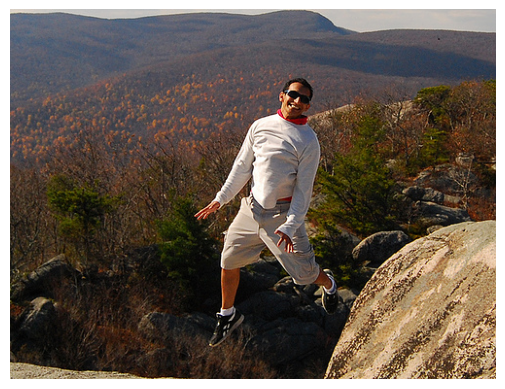

1/1 [==============================] - 0s 32ms/step
man in red shirt and khaki shirt is climbing rock face


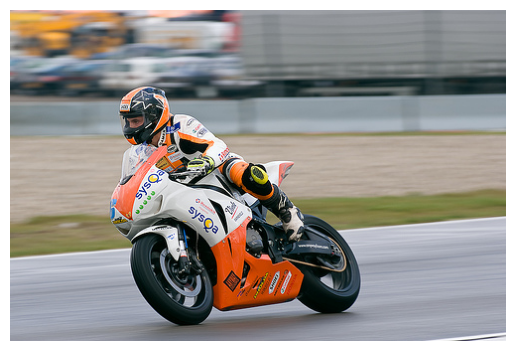

1/1 [==============================] - 0s 37ms/step
man in blue shirt and helmet riding green bike


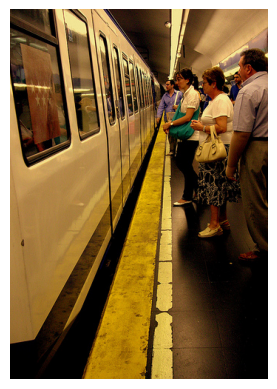

1/1 [==============================] - 0s 31ms/step
man in black shirt is standing in front of traffic


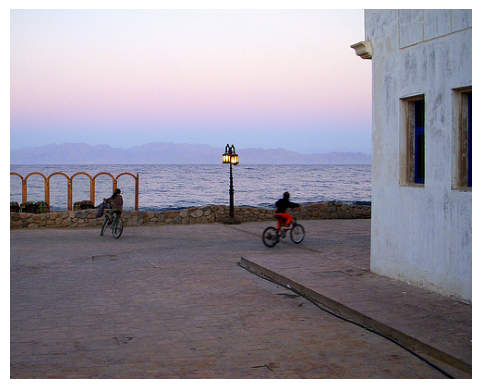

1/1 [==============================] - 0s 40ms/step
man and woman are sitting on bench with their bicycles in the background


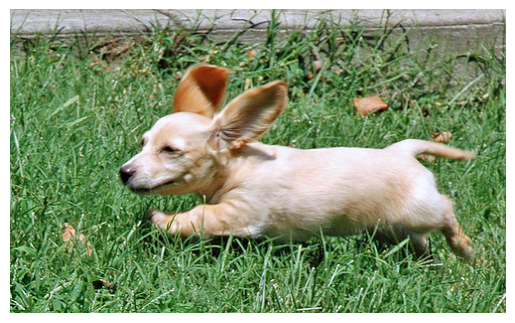

1/1 [==============================] - 0s 32ms/step
two dogs are running through field


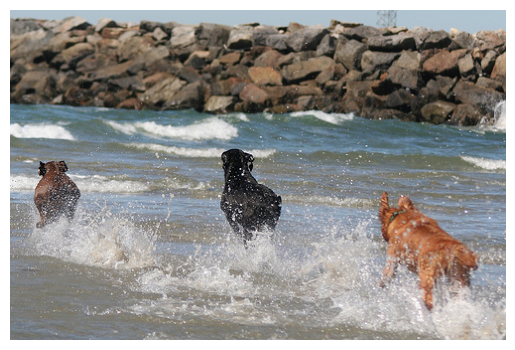

1/1 [==============================] - 0s 33ms/step
two dogs play in the water


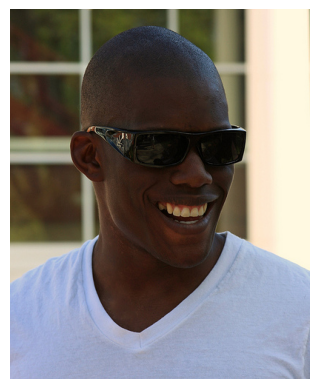

1/1 [==============================] - 0s 22ms/step
man with nose and glasses


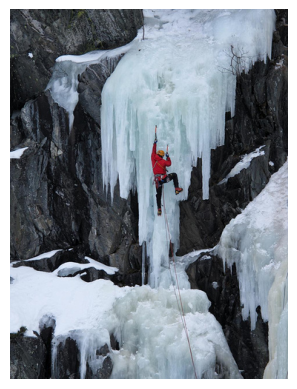

1/1 [==============================] - 0s 26ms/step
two people are standing on top of snowy mountain


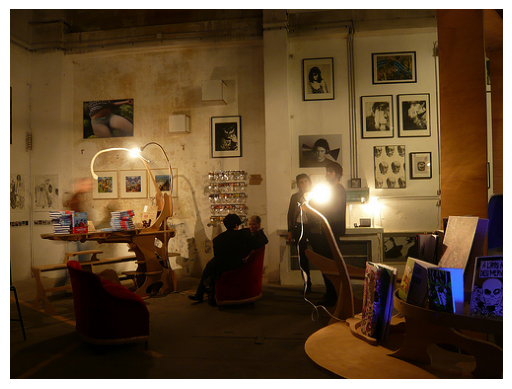

1/1 [==============================] - 0s 33ms/step
people are sitting on the floor at night


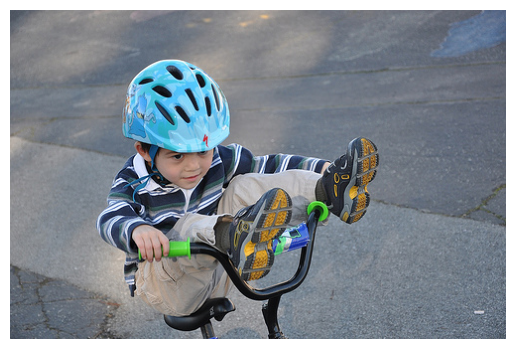

1/1 [==============================] - 0s 28ms/step
man in blue shirt and helmet riding his bike in the snow


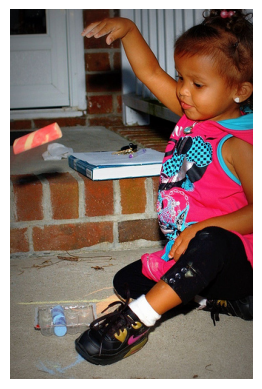

1/1 [==============================] - 0s 40ms/step
boy in blue shirt is playing with toy


In [62]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)